In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,...,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000
mean,53.508956,48.304978,39.143467,35.864142,33.853582,32.708766,31.009252,30.532134,29.889138,29.160472,...,-0.090844,0.072819,-0.077106,0.055085,-0.060978,0.036545,-0.051914,0.026218,0.631143,24.580783
std,25.265697,23.647203,15.790348,14.114633,13.635226,13.107436,12.420995,12.327251,12.303024,11.835478,...,0.187875,0.186975,0.177108,0.178257,0.173116,0.171906,0.169026,0.166759,0.482512,14.504488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.608988,-0.549936,-0.600307,-0.541945,-0.571735,-0.567479,-0.657158,-0.652748,0.000000,0.000000
25%,36.699715,32.942266,29.300557,26.795949,25.189006,24.263592,22.967298,22.581471,21.864301,21.577288,...,-0.228436,-0.051829,-0.206126,-0.066705,-0.187531,-0.083388,-0.173806,-0.089127,0.000000,12.000000
50%,52.504467,46.275288,40.232948,37.269062,34.792385,33.761940,32.032204,31.681557,30.886330,30.283770,...,-0.098217,0.073805,-0.080750,0.052019,-0.059712,0.032450,-0.052382,0.021335,1.000000,25.000000
75%,69.931293,61.654675,49.519983,45.619434,43.156816,41.639572,39.837561,39.272337,38.593704,37.789133,...,0.034678,0.208973,0.043096,0.184355,0.056283,0.159392,0.065436,0.145170,1.000000,37.000000
max,185.616364,166.130890,108.506081,90.964890,90.135765,97.072968,70.160568,76.352196,74.793617,80.134895,...,0.558040,0.640284,0.536997,0.585758,0.516501,0.569030,0.544415,0.522034,1.000000,49.000000


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

# Deep Net
Separate into classes

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(114,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [15]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

9532/9532 [==============================] - 1s 60us/step - loss: 2.1526 - acc: 0.3889 - val_loss: 2.0457 - val_acc: 0.4272
Epoch 49/200
9532/9532 [==============================] - 1s 59us/step - loss: 2.1209 - acc: 0.3931 - val_loss: 2.0457 - val_acc: 0.4225
Epoch 50/200
9532/9532 [==============================] - 1s 60us/step - loss: 2.1266 - acc: 0.3925 - val_loss: 2.0499 - val_acc: 0.4314
Epoch 51/200
9532/9532 [==============================] - 1s 59us/step - loss: 2.1145 - acc: 0.3944 - val_loss: 2.0287 - val_acc: 0.4361
Epoch 52/200
9532/9532 [==============================] - 1s 58us/step - loss: 2.1189 - acc: 0.4010 - val_loss: 2.0211 - val_acc: 0.4337
Epoch 53/200
9532/9532 [==============================] - 1s 59us/step - loss: 2.1078 - acc: 0.3975 - val_loss: 2.0282 - val_acc: 0.4290
Epoch 54/200
9532/9532 [==============================] - 1s 58us/step - loss: 2.0995 - acc: 0.4018 - val_loss: 2.0363 - val_acc: 0.4367
Epoch 55/200
9532/9532 [==============================

Epoch 108/200
9532/9532 [==============================] - 1s 57us/step - loss: 1.8029 - acc: 0.4788 - val_loss: 1.8566 - val_acc: 0.4890
Epoch 109/200
9532/9532 [==============================] - 1s 58us/step - loss: 1.7943 - acc: 0.4813 - val_loss: 1.8436 - val_acc: 0.4854
Epoch 110/200
9532/9532 [==============================] - 1s 60us/step - loss: 1.7870 - acc: 0.4833 - val_loss: 1.8394 - val_acc: 0.4938
Epoch 111/200
9532/9532 [==============================] - 1s 60us/step - loss: 1.7866 - acc: 0.4867 - val_loss: 1.8686 - val_acc: 0.4771
Epoch 112/200
9532/9532 [==============================] - 1s 61us/step - loss: 1.7978 - acc: 0.4844 - val_loss: 1.8044 - val_acc: 0.5045
Epoch 113/200
9532/9532 [==============================] - 1s 58us/step - loss: 1.7876 - acc: 0.4866 - val_loss: 1.8304 - val_acc: 0.5015
Epoch 114/200
9532/9532 [==============================] - 1s 59us/step - loss: 1.7831 - acc: 0.4898 - val_loss: 1.8526 - val_acc: 0.4961
Epoch 115/200
9532/9532 [=========

9532/9532 [==============================] - 1s 57us/step - loss: 1.6645 - acc: 0.5221 - val_loss: 1.7848 - val_acc: 0.5098
Epoch 168/200
9532/9532 [==============================] - 1s 59us/step - loss: 1.6447 - acc: 0.5276 - val_loss: 1.7800 - val_acc: 0.5223
Epoch 169/200
9532/9532 [==============================] - 1s 59us/step - loss: 1.6348 - acc: 0.5299 - val_loss: 1.7808 - val_acc: 0.5181
Epoch 170/200
9532/9532 [==============================] - 1s 58us/step - loss: 1.6208 - acc: 0.5298 - val_loss: 1.7803 - val_acc: 0.5175
Epoch 171/200
9532/9532 [==============================] - 1s 60us/step - loss: 1.6410 - acc: 0.5309 - val_loss: 1.7746 - val_acc: 0.5068
Epoch 172/200
9532/9532 [==============================] - 1s 58us/step - loss: 1.6066 - acc: 0.5336 - val_loss: 1.7886 - val_acc: 0.5181
Epoch 173/200
9532/9532 [==============================] - 1s 60us/step - loss: 1.6172 - acc: 0.5336 - val_loss: 1.7665 - val_acc: 0.5223
Epoch 174/200
9532/9532 [=======================

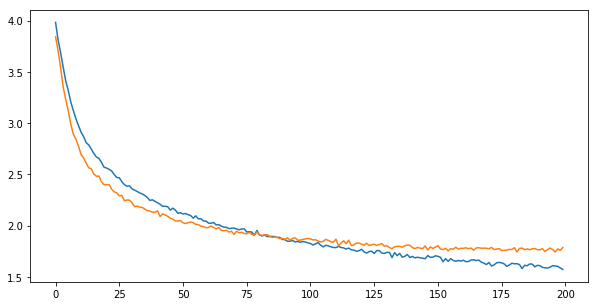

In [16]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

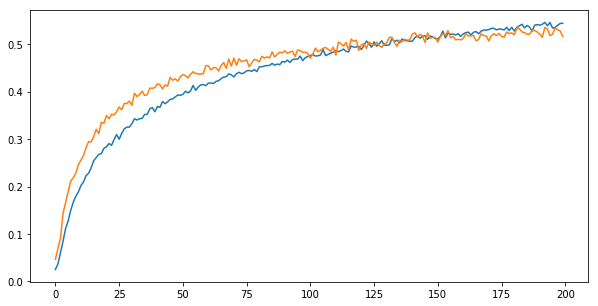

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5189015691868759
Confusion matrix, without normalization
[[14  1  1 ...  1  5  1]
 [ 0 16  0 ...  1  2  0]
 [ 0  0 17 ...  0  1  3]
 ...
 [ 0  0  2 ... 35  5  0]
 [ 4  1  0 ...  2 36  0]
 [ 3  0  0 ...  0  2 36]]


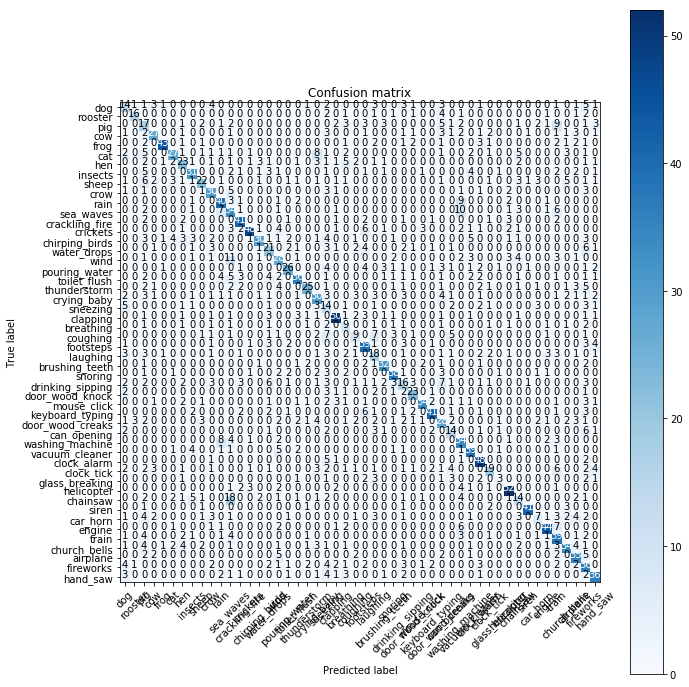

In [18]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [19]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 88ms/step - loss: 1.2473
Epoch 1/1
2/2 [==============================] - 0s 102ms/step - loss: 1.3298
	Bytes: 52686352
	Processing Time: 228.5557107925415


In [20]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['h_target']

0.12810441399232042
Confusion matrix, without normalization
[[234   9  29 ...   5  75  37]
 [ 60  60  21 ...  18  41   5]
 [ 33   2 119 ...  19  35  66]
 ...
 [ 10  21  62 ... 275  44   2]
 [ 42   4  56 ...  11 411  10]
 [  8   0  50 ...   2   4 446]]


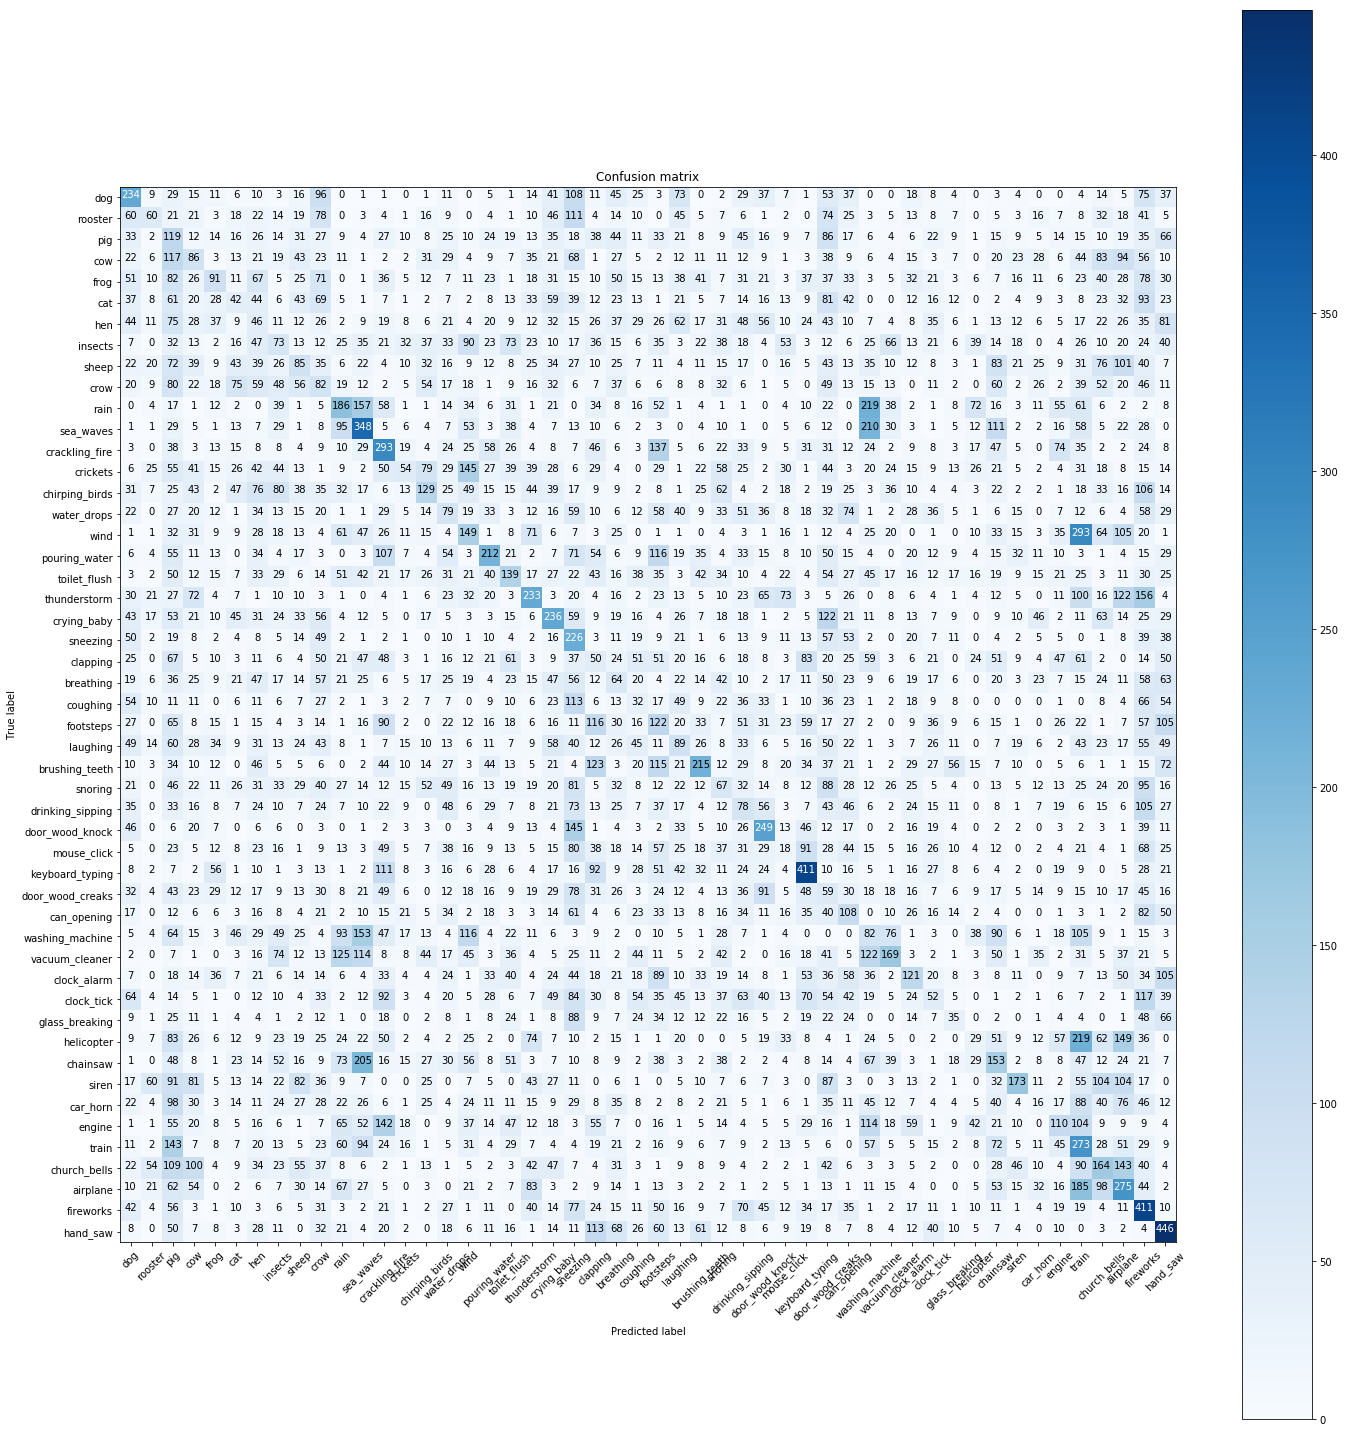

In [21]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()